In [39]:
#import modules
import numpy as np
import csv
from scipy import special
import matplotlib.pyplot as plt
import scipy.optimize

In [40]:
#helper function to read file
def readFile(fileName):
    with open(fileName) as f:
        reader = csv.reader(f, delimiter="\t")
        d = list(reader)
    return d


In [41]:
# This function evaluates a normalized sum of N Gaussian functions with
# means specified by the input vector mu and standard deviation equal to s
# The function is computed in each point of the input vector x.
#Nota que el vector x que le metes abarca el rango de todas las gaussian y se van sumando los valores
def sumGaussian(x, mu, s):
    N = len(mu)
    G = 0
    for i in range(N):
        G = G + np.exp((-(x-mu[i])**2)/((2*(s**2))))/(np.sqrt(2*np.pi*(s**2)))
    G = G/N #Normalization
    
    return G
        

In [59]:
# Al final hacer for loop para todas las crpto!!"!!!!!!!!!"

file = readFile("cryptocurrency_prices.txt")
data = file

# Row 1: Bitcoin      (p = 6.14e-13)
# Row 2: Dash         (p = 2.17e-02)
# Row 3: Ethereum     (p = 6.31e-04)
# Row 4: Litecoin     (p = 6.32e-07)
# Row 5: Monero       (p = 6.41e-03)
# Row 6: Nem          (p = 3.63e-01)
# Row 7: Ripple       (p = 1.04e-03)

crypto = ["bitcoin","Dash","Ethereum","Litecoin","Monero","Nem","Ripple"]

# var values becuase we have 7 cryptocurrencies
var_hist = np.zeros(7)
var_kernel=np.zeros(7)
var_test=np.zeros(7)
es_hist=np.zeros(7)
es_kernel=np.zeros(7)
es_test=np.zeros(7)

for j in range(7):

    b = data[j]

    # Log-returns
    r = np.zeros((len(b)-1,1))
    for i in range(len(b)-1):
        den = float(b[i])
        num = float(b[i+1])
        r[i] = np.log(num/den)

    #Separating the data into training / validation / testing sets (one third of the data each)
    pt = 0.33 #Fraction of data to use in training set
    pv = 0.33 #Fraction of data to use in validation set

    # Indexes at 33% and 66% of the data
    index33= int(np.round(pt*len(r)))
    index66 = int(np.round((pt+pv)*len(r)))

    train_set = r[:index33] # [Training set ] first 33% of the data of r
    N_T = len(train_set)

    val_set = r[index33:index66] # [Validation set ] second 33% of the data of r

    test_set = r[index66:] # [Test set ] third 33% of the data of r

    # <<<<<<<<<<<<<<<<<<<<<<<<<<.   << Maximum likelihood analysis >>.    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

    # Vector of different standard deviations from 1^(-3) to 1^(-1) in log scales with 100 values
    h = np.logspace(-3,-1,100) 
    L = np.zeros((len(h),1))

    #Literal itera con todos los diferentes values de S.D para saber Mac Likelihood
    #En otras ocaciones usabamos funciones de maximizacion y no era tan facil porque habia que maximizar
    # multiples variables
    for i in range(len(h)):
        #Computing log-likelihood for Gaussian kernel evaluated on the
        #validation set (using the training set as fixed parameters)

        p = sumGaussian(val_set,train_set,h[i]) #Vector of Gaussian kernel values calculated in each point of validation set
        aux = np.sum(np.log(p)) #Computing likelihood

        L[i] = aux
    h_opt = h[np.where(L == max(L))[0]] #agarra el valor de h en el indice donde esta el max L
    print("optimal kernel standard deviation for ",crypto[j]," = ", h_opt)

    # <<<<<<<<<<<<<<<<<<<<<<<<<<.   << Kernel Random Numbers >>.    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

    f = lambda x, u: sum(1+scipy.special.erf((x-train_set)/np.sqrt(2*h_opt**2)))/(2*N_T) - u
    n_rand = 5000
    kernel_random_numbers = np.zeros(n_rand)

    for i in range(n_rand):
        u = np.random.uniform()
        y = scipy.optimize.fsolve(f,0,args = (u))
        kernel_random_numbers[i] = y

    # In Kernel_Gaussian notebook this variable is train_val (combination of train set and validation set)
    historical = np.concatenate((train_set,val_set), axis=0);

    alpha = 0.95
    
    # VaR [Value at Risk]
    var_hist[j] = np.absolute(np.quantile(historical,1-alpha))
    var_kernel[j] = np.absolute(np.quantile(kernel_random_numbers,1-alpha))
    # ES [Expected Shortfall]
    es_hist[j] =np.absolute(np.mean([[v]  for v in historical if v < -var_hist[j]])) # Used list comprehension
    es_kernel[j] =np.absolute(np.mean([[m]  for m in kernel_random_numbers if m < -var_kernel[j]]))

    #VaR and ES for Test set
    var_test[j] = np.absolute(np.quantile(test_set,1-alpha))
    es_test[j] =np.absolute(np.mean([[k]  for k in historical if k < -var_test[j]]))

optimal kernel standard deviation for  bitcoin  =  [0.0070548]


<ipython-input-59-94f29c149ee9>:64: RuntimeWarning: divide by zero encountered in log
  aux = np.sum(np.log(p)) #Computing likelihood


optimal kernel standard deviation for  Dash  =  [0.02595024]
optimal kernel standard deviation for  Ethereum  =  [0.01555676]


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


optimal kernel standard deviation for  Litecoin  =  [0.02983647]
optimal kernel standard deviation for  Monero  =  [0.04977024]
optimal kernel standard deviation for  Nem  =  [0.0225702]
optimal kernel standard deviation for  Ripple  =  [0.06892612]


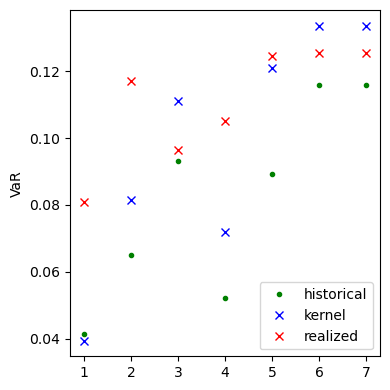

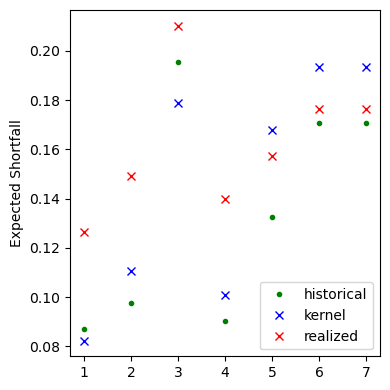

In [67]:



plot1 = plt.figure(1,figsize=(4,4), dpi=100)
for i in range(6):
    plt.plot(i+1,var_hist[i],"g.")
    plt.plot(i+1,var_kernel[i],"bx")
    plt.plot(i+1,var_test[i], "rx")
    plt.ylabel("VaR")
    plt.tight_layout()
plt.plot(7,var_hist[i],"g.",label = "historical")
plt.plot(7,var_kernel[i],"bx",label = "kernel")
plt.plot(7,var_test[i], "rx",label = "realized")
plt.legend()


plot2 = plt.figure(2,figsize=(4,4), dpi=100)
for i in range(6):
    plt.plot(i+1,es_hist[i],"g.")
    plt.plot(i+1,es_kernel[i],"bx")
    plt.plot(i+1,es_test[i],"rx")
    plt.ylabel("Expected Shortfall")
    plt.tight_layout()

plt.plot(7,es_hist[i],"g.",label = "historical")
plt.plot(7,es_kernel[i],"bx",label = "kernel")
plt.plot(7,es_test[i],"rx",label = "realized")
plt.legend()

# 1: Bitcoin
# 2: Dash 
# 3: Ethereum 
# 4: Litecoin  
# 5: Monero  
# 6: Nem    
# 7: Ripple 